<a href="https://colab.research.google.com/github/kobeisfree94/Projects/blob/master/Fake_News_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from tensorflow.keras.utils import plot_model


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

train = pd.read_csv('/content/gdrive/My Drive/DataSets/Fake News/train.csv')

train.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(20800, 5)

0: Fake News
1: Real News

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
#Check Missing Values
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
train = train.fillna('')

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#Check Stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
X_train = train.drop(columns='label', axis=1)
y_train = train['label']

In [9]:
#Set Vocab Size 
vo_size=500
content=X_train.copy()
content.reset_index(inplace=True)

Stemming-- process of reducing the word to the root word

In [10]:
#PorterStemmer
port_stem = PorterStemmer()
corpus = []
for i in range(0, len(content)):
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content['text'][i])
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  corpus.append(stemmed_content)

onehot_rep = [one_hot(words, vo_size) for words in corpus]
sent_length = 1000
embedded_doc = pad_sequences(onehot_rep, padding ='pre', maxlen = sent_length)
print(embedded_doc)

In [13]:
#Model
embedding_vector_feature = 100
model=Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(200))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         50000     
                                                                 
 lstm (LSTM)                 (None, 200)               240800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 291,001
Trainable params: 291,001
Non-trainable params: 0
_________________________________________________________________
None


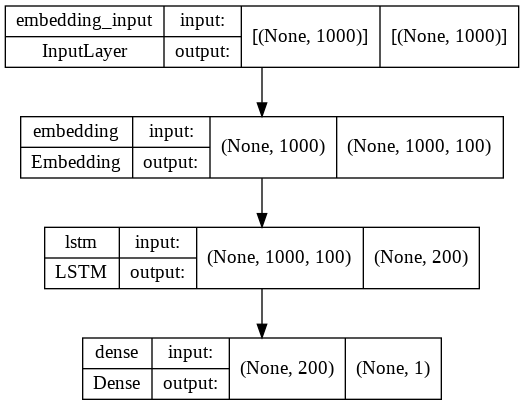

In [14]:
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [15]:
len(embedded_doc),y_train.shape

(20800, (20800,))

In [16]:
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20800, 1000), (20800,))

In [17]:
#Train Model
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

Epoch 1/10
65/65 [==============================] - 606s 9s/step - loss: 0.5725 - accuracy: 0.6761 - val_loss: 0.4079 - val_accuracy: 0.8228
Epoch 2/10
65/65 [==============================] - 621s 10s/step - loss: 0.3460 - accuracy: 0.8552 - val_loss: 0.3076 - val_accuracy: 0.8750
Epoch 3/10
65/65 [==============================] - 603s 9s/step - loss: 0.3169 - accuracy: 0.8722 - val_loss: 0.3064 - val_accuracy: 0.8793
Epoch 4/10
65/65 [==============================] - 601s 9s/step - loss: 0.2765 - accuracy: 0.8913 - val_loss: 0.2931 - val_accuracy: 0.8743
Epoch 5/10
65/65 [==============================] - 600s 9s/step - loss: 0.2548 - accuracy: 0.8969 - val_loss: 0.3030 - val_accuracy: 0.8623
Epoch 6/10
65/65 [==============================] - 599s 9s/step - loss: 0.2427 - accuracy: 0.9029 - val_loss: 0.3014 - val_accuracy: 0.8781
Epoch 7/10
65/65 [==============================] - 599s 9s/step - loss: 0.2375 - accuracy: 0.9053 - val_loss: 0.2710 - val_accuracy: 0.8846
Epoch 8/10
6

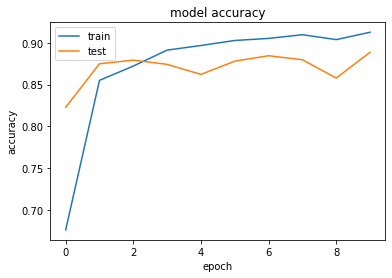

In [19]:
#Summary for Model Accuracy/Val Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

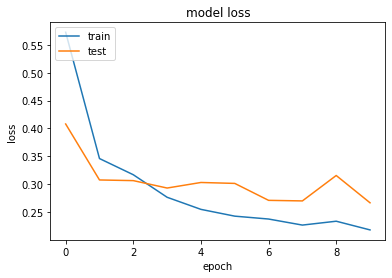

In [20]:
#Summary for Model Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()